In [1]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Toy Model

In [4]:
###Color palette
orders = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'No Control': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}

###Helper functions
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

###Model definition
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

###Search space definition
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 0.001, 10), hp.uniform('k1_ur', 1E-7, 1E-3)], [2., hp.uniform('theta2_ur', 0.001, 10), hp.uniform('k2_ur', 1E-7, 1E-3)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 0.001, 10), hp.uniform('k1_nc', 1E-7, 1E-3)], [2., hp.uniform('theta2_nc', 0.001, 10), hp.uniform('k2_nc', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 0.001, 10), hp.uniform('k1_dc', 1E-7, 1E-3)], [2., hp.uniform('theta2_dc', 0.001, 10), hp.uniform('k2_dc', 1E-7, 1E-3)]])])
    

###Objective function
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E4, 100) 
        y0 = np.array([2290., 0., 0., 0., 0., 0.])

        extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
        ode_solver = ode('cvode', toy_model, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)

        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    landscape = pd.DataFrame({'Circuit':circuits, 'Loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    landscape['Circuit'] = [name_converter(c) for c in landscape.Circuit]
    return landscape, best

In [22]:
###Run single architecture search to impute landscape
max_iters = 1000

space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
da_landscape, best = run_hyperopt(max_iters)

space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
ur_landscape, best = run_hyperopt(max_iters)

space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
nc_landscape, best = run_hyperopt(max_iters)

space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
dc_landscape, best = run_hyperopt(max_iters)


100%|██████████| 1000/1000 [00:45<00:00, 21.92trial/s, best loss: 0.06383548398261338]


In [64]:
landscape = pd.concat([dc_landscape, nc_landscape, ur_landscape, da_landscape])
landscape.to_csv('single_architecture_run.csv')

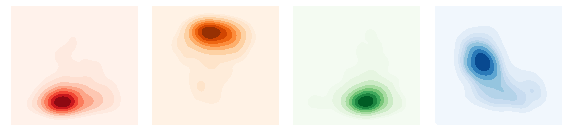

In [65]:
###FIGURE: Landscapes for each architecture
fig, axs = plt.subplots(1,4,figsize=(8, 2))
landscapes = [nc_landscape, ur_landscape, da_landscape, dc_landscape]
colors = ['Reds','Oranges','Greens', 'Blues']
singlecolors = ['red', 'orange', 'green', 'blue']

for i in range(4):
    landscape = landscapes[i]
    ax = axs[i]
    sns.kdeplot(data=landscape, x='theta1', y ='k1', cmap=colors[i], shade=True, thresh=0, ax=ax)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    for spine in ax.spines.values():
        spine.set_edgecolor(None)

fig.tight_layout()
fig.savefig('landscapes.png', dpi=300)